# Week 4 Activity: Delay, Filters, Reverb

Complete this activity as part of your participation grade. Pending length of the lecture, you will have time in class to work. Everything you need to complete this activity can be found in this week's (or a previous week's) lecture code. For this activity, you may want to consult your Audio Tech I notes (or the Computer Music Tutorial)

In [4]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import sawtooth, square, butter, filtfilt
import matplotlib.pyplot as plt
from IPython.display import Audio, Image

## Delay
1) Create a function that will modify a passed signal by adding a delay of $m$ milliseconds to the signal.

In [5]:
def delay_1(x, m, fs=44100):
    copy = x.copy()
    delay_samples = int(fs/1000 * m)
    pad = np.zeros(delay_samples)
    orig = np.concatenate([x, pad])
    delay = np.concatenate([pad, copy])
    return orig + delay

2) Modify the function such that you can optionally scale the amplitude of the delayed signal 

In [6]:
#my function assumes delay amplitude is given as a percentage
def delay_2(x, m, amp_delay=0.5, fs=44100):
    copy = x.copy()
    delay_samples = int(fs/1000 * m)
    pad = np.zeros(delay_samples)
    orig = np.concatenate([x, pad])
    delay = np.concatenate([pad, copy]) * amp_delay
    return orig + delay

3) Modify the function so that the user can specify the number of delays to add to the original signal (and optionally, scale each subsequent delay amplitude by a factor of $1/n$

In [24]:
# This time I built the delay with pre-allocated buffers/arrays
def delay_3(x, m, num_delays=1, fs=44100):
    delay_samples = int(fs/1000 * m)
    delay = np.zeros(len(x) + (delay_samples * num_delays))
    delay[:len(x)] += x
    for n in range(1, num_delays+1):
        start_ind = n * delay_samples
        end_ind = start_ind + len(x)
        delay[start_ind:end_ind] += x * 1/n
    return delay

## Filters
1. Create a function that will apply an feedforward comb filter by computing the delay length based off a given resonant frequency in Hz.

The inverse of the delay time (in seconds) gives us the fundamental of the delay. So, there will be peaks at multiples of 1/delay time.

If our delay time is 2 ms at a sampling rate of 44100 Hz, what is the length of the delay and where are our peaks?

In [25]:
def FFCF(x, freq, g=0.8, fs=44100):
    delay_s = 1/freq
    delay_in_samples = int(fs / delay_s)

    y = np.zeros_like(x)
    for n in range(len(x)):
        y[n] = x[n]
        if n - delay_in_samples >= 0:
            y[n] += g * x[n - delay_in_samples]

2. Create a function that will apply an feedback comb filter by computing the delay length based off a given resonant frequency in Hz.

In [26]:
def FFCF(x, freq, g=0.8, fs=44100):
    delay_s = 1/freq
    delay_in_samples = int(fs / delay_s)

    y = np.zeros_like(x)
    for n in range(len(x)):
        y[n] = x[n]
        if n - delay_in_samples >= 0:
            y[n] += g * y[n - delay_in_samples]

4. Use your comb filter functions on a wave from the audio folder. Try applying different resonant frequencies and delay lengths. How are the filter results different?

3. Create a function that will apply a butterworth filter to a signal with filter type options 'highpass', 'lowpass', 'bandpass', and 'bandstop'.

In [1]:
def butterworth(x, type, cutoff, order, fs=44100):
    (b, a) = butter(order, cutoff, btype=type, fs=fs)
    return filtfilt(b, a, x)

## Reverb/Convolution

1. Create a function that will apply a simple moving average filter by convolving the filter kernel and an incoming signal.

In [2]:
def moving_avg(x, M=10):
    h = np.ones(M) / M  # Filter kernel
    out = np.convolve(x, h)
    return out

2. Apply your filter to a noise signal. What is the effect? What happens if you increase or decrease the kernel size?

(array([1.30534157e-02, 1.13726765e-02, 5.28761985e-03, ...,
        1.43632036e-06, 8.07801606e-07, 6.22687790e-07]),
 array([0.00000000e+00, 9.05018327e-05, 1.81003665e-04, ...,
        9.99773745e-01, 9.99864247e-01, 9.99954749e-01]),
 <matplotlib.lines.Line2D at 0x7fba0ba4da50>)

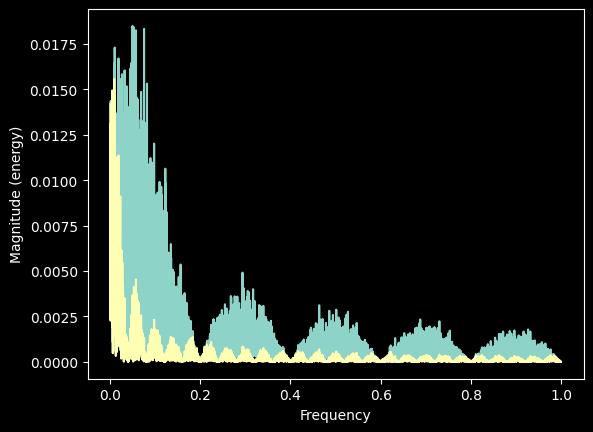

In [5]:
fs = 44100
dur = 0.5
x = np.random.normal(0, 1, int(fs*dur))

out = moving_avg(x, 10)
plt.magnitude_spectrum(out)

out = moving_avg(x, 50)
plt.magnitude_spectrum(out)

3. Create a function that applies convolution reverb to an input signal given an impulse response (this can be default loaded from the audio files). Use np.convolve to create this function.

In [6]:
def reverb(x, ir='../audio/impulse-response.wav'):
    return np.convolve(x, ir)

4. Create another function that applies convolution reverb to an input signal given an impulse response, but this time do not use np.convolve. You should write the convolution from scratch.

    Challenge yourself to create the most efficient function and time your implementation against np.convolve. 
    While developing and testing your function, do not use real audio files. Start with short signals (e.g., impulses, noise, or short sinusoids). Using long signals with loop-based implementations will result in extremely slow run times.

    **Hint:** in a similar manner to how you may have designed your delay function, recall the functions `numpy.zeros` and `numpy.roll` along with how to manipulate multidimensional numpy arrays (e.g., scalar product, summing columns with `vstack`, etc.) If you plan to try `numpy.roll` DO NOT use it in a loop for convolution with a real audio file! (You'll kill your memory), instead consider the `map` function. You may also want to check out the following function which is similar to numpy.roll but more efficient for this task: `scipy.linalg.circulant`.

    You may wish to visit [here](https://numpy.org/doc/stable/user/basics.broadcasting.html) for review of broadcasting (i.e., form some calculation across index value I and column value C) in numpy

We need to multiply signal g by signal f over time and add at each time position. This looks like sliding signal g across signal f. The result is the output of the convolution at that time position.

| 2  | 4  | 3  | 6  |   |   |   |   | Result|
|-|-|-|-|-|-|-|-|-|
| 1  |   |   |  |  |   |  |   | 2(1) = 2
|  5 | 1  |  |   |   |   |   |   | 2(5) + 4(1) = 14
|  2 | 5 |  1 |   |   |   |   |   | 2(2) + 4(5) + 3(1) = 27
|  3 | 2  | 5  | 1  |   |   |   |   |2(3) + 4(2) + 3(5) + 6(1) = 35
|  4 | 3  | 2  | 5  |   |   |   |   |2(4) + 4(3) + 3(2) + 6(5) = 56
|   | 4  | 3  | 2  |  |   |   |   |4(4) + 3(3) + 6(2) = 56
|   |   | 4  | 3  |  |   |   |   |4(4) + 3(3) + 6(2) = 37
|   |   |   | 4  |  |   |   |   |4(4) + 3(3) + 6(2) = 30